# King County

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/kingcounty/raw/kc_house_data.csv');
df.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1435,133000135,20141120T000000,290000.0,4,1.75,1990,18900,2.0,0,0,...,7,1870,120,1929,0,98168,47.5131,-122.313,1710,12400
2892,7574000100,20150408T000000,350000.0,3,1.75,1580,19998,1.0,0,0,...,7,1580,0,1968,0,98010,47.3299,-122.046,1860,19998
17010,8680300010,20150324T000000,290000.0,3,2.00,1360,6685,1.0,0,0,...,7,1360,0,1952,0,98155,47.7365,-122.324,1300,8138


In [2]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
syn = Synthetic(df,
                    id="id",
                    category_columns=("condition", "floors", "grade", "view", "waterfront", "yr_built", "yr_renovated", "zipcode", "bathrooms", "bedrooms",),
                    #category_columns=("condition", "floors", "grade", "view","waterfront", "zipcode", "bathrooms", "bedrooms",),
                    synthetic_folder="../datasets/kingcounty/synth-a-2",
                    models=MODELS.keys(),
                    n_sample=21613,
                    max_cpu_pool=1,
                    target_column="price"
                    )

In [3]:
syn.process()

syn.process_scores()


Fitting Models
Params
{'metadata': {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "id": {
            "sdtype": "numerical"
        },
        "date": {
            "sdtype": "categorical"
        },
        "price": {
            "sdtype": "numerical"
        },
        "bedrooms": {
            "sdtype": "categorical"
        },
        "bathrooms": {
            "sdtype": "categorical"
        },
        "sqft_living": {
            "sdtype": "numerical"
        },
        "sqft_lot": {
            "sdtype": "numerical"
        },
        "floors": {
            "sdtype": "categorical"
        },
        "waterfront": {
            "sdtype": "categorical"
        },
        "view": {
            "sdtype": "categorical"
        },
        "condition": {
            "sdtype": "categorical"
        },
        "grade": {
            "sdtype": "categorical"
        },
        "sqft_above": {
            "sdtype": "numerical"
        },
        "sqft_basement":

## Metricas
### Continuas

In [4]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

long
yr_renovated
price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living
yr_built
lat
sqft_basement


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: Ru

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
0,long,"[-122.29, -122.362, -122.288, -122.3, -122.372]","[100, 88, 81, 81, 81]","[0.00578368999421631, 0.005089647194910353, 0....",False,17290.0,0.0,-122.214139,0.001068,-122.212045,...,0.005784,-122.2310,-122.497000,-122.408000,-122.3870,-122.329,-122.125,-1.219790e+02,-1.217870e+02,-1.216989e+02
1,yr_renovated,"[0, 2014, 2005, 2000, 2003]","[16571, 76, 32, 30, 29]","[0.9584152689415847, 0.004395604395604396, 0.0...",False,17290.0,0.0,83.003412,3.030640,88.943358,...,0.958415,0.0000,0.000000,0.000000,0.0000,0.000,0.000,0.000000e+00,2.008000e+03,2.014000e+03
5,price,"[350000.0, 450000.0, 425000.0, 550000.0, 32500...","[143, 140, 123, 123, 123]","[0.008270676691729323, 0.008097165991902834, 0...",False,17290.0,0.0,537768.047947,2748.953957,543155.898699,...,0.008271,450000.0000,95000.000000,154467.000000,210000.0000,320150.000,640000.000,1.150000e+06,1.950000e+06,3.331995e+06
6,sqft_living15,"[1440, 1540, 1560, 1500, 1610]","[156, 154, 152, 137, 136]","[0.009022556390977444, 0.008906882591093117, 0...",False,17290.0,0.0,1982.904569,5.180812,1993.058774,...,0.009023,1840.0000,740.000000,950.000000,1140.0000,1480.000,2360.000,3.280000e+03,4.050000e+03,4.985550e+03
8,sqft_lot,"[5000, 4000, 6000, 7200, 4800]","[301, 209, 208, 179, 98]","[0.017408906882591092, 0.012087912087912088, 0...",False,17290.0,0.0,14798.947368,295.374719,15377.871180,...,0.017409,7600.0000,737.156000,1005.000000,1756.0000,5001.250,10606.750,4.299910e+04,2.121922e+05,4.356000e+05
10,sqft_lot15,"[5000, 4000, 6000, 7200, 4800]","[349, 289, 224, 160, 120]","[0.02018507807981492, 0.016714864083285135, 0....",False,17290.0,0.0,12725.059341,209.331173,13135.340900,...,0.020185,7615.0000,886.289000,1189.000000,1965.0000,5083.000,10046.000,3.682165e+04,1.682959e+05,3.069984e+05
11,sqft_above,"[1300, 1010, 1200, 1220, 1140]","[166, 165, 160, 152, 148]","[0.009600925390399074, 0.009543088490456911, 0...",False,17290.0,0.0,1785.962175,6.248515,1798.209039,...,0.009601,1560.0000,520.000000,700.000000,850.0000,1200.000,2200.000,3.380000e+03,4.371100e+03,6.070000e+03
12,sqft_living,"[1400, 1300, 1720, 1250, 1540]","[109, 107, 106, 106, 105]","[0.006304222093695778, 0.006188548293811452, 0...",False,17290.0,0.0,2073.894910,6.900053,2087.418766,...,0.006304,1910.0000,522.890000,720.000000,940.0000,1430.000,2540.000,3.740000e+03,4.921100e+03,6.965550e+03
15,yr_built,"[2014, 2005, 2006, 2004, 2007]","[449, 371, 366, 350, 347]","[0.025968768074031232, 0.02145748987854251, 0....",False,17290.0,0.0,1971.108329,0.223859,1971.547085,...,0.025969,1975.0000,1900.000000,1904.000000,1915.0000,1951.000,1997.000,2.011000e+03,2.014000e+03,2.015000e+03
16,lat,"[47.5402, 47.6875, 47.686, 47.6624, 47.5518]","[14, 13, 13, 13, 13]","[0.0008097165991902834, 0.0007518796992481203,...",False,17290.0,0.0,47.560330,0.001053,47.562393,...,0.000810,47.5718,47.192729,47.257334,47.3107,47.472,47.678,4.774995e+01,4.777281e+01,4.777670e+01


In [5]:
print(metrics[~metrics.is_categorical].dropna(axis=1, how='all').head(1).T
      #.style.to_latex()
      )

                                                                  0
name                                                           long
top5                [-122.29, -122.362, -122.288, -122.3, -122.372]
top5_freq                                     [100, 88, 81, 81, 81]
top5_prob         [0.00578368999421631, 0.005089647194910353, 0....
is_categorical                                                False
nobs                                                        17290.0
missing                                                         0.0
mean                                                    -122.214139
std_err                                                    0.001068
upper_ci                                                -122.212045
lower_ci                                                -122.216233
std                                                        0.140498
iqr                                                           0.204
iqr_normal                                      

### Categoricas

In [6]:
metrics[metrics.is_categorical].dropna(axis=1, how='all').head(1).T.to_markdown()

/root/.local/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)
/root/.local/lib/python3.10/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


'|                | 2                                                        |\n|:---------------|:---------------------------------------------------------|\n| name           | floors                                                   |\n| top5           | [1.  2.  1.5 3.  2.5]                                    |\n| top5_freq      | [8488 6628 1523  517  128]                               |\n| top5_prob      | [0.49091961 0.38334297 0.0880856  0.02990168 0.00740312] |\n| is_categorical | True                                                     |\n| nobs           | 17290.0                                                  |\n| missing        | 17290.0                                                  |'

In [7]:
len(metrics[~metrics.is_categorical].dropna(axis=1, how='all').columns)-1+len(metrics[metrics.is_categorical].dropna(axis=1, how='all').columns)-1

40

## Scores

In [8]:
best_model = "tddpm_mlp"
second_best_model = "smote-enc"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False).loc[:,["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]
#["tddpm_mlp_21613","smote-enc_21613","gaussiancopula_noise_21613","tvae_21613", "tvae_noise_21613","gaussiancopula_21613","copulagan_noise_21613","copulagan_21613","ctgan_noise_21613","ctgan_21613"]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
smote-enc,0.953092,0.007176,0.037052,0.03575
tddpm_mlp,0.949377,0.057187,0.075128,0.03575
tablepreset,0.836980,0.180160,0.199969,0.03575
ctgan,0.800950,0.227065,0.250021,0.03575
copulagan,0.791372,0.381154,0.415932,0.03575
gaussiancopula,0.787893,0.262619,0.306095,0.03575
tvae,0.750843,0.081287,0.098688,0.03575


In [31]:
syn.scores[syn.scores["type"] == "avg"].sort_values("score", ascending=False).loc[:,["DCR ST 5th", "DCR SH 5th", "DCR TH 5th","score"]].reset_index().rename(columns={'name':"Modelo", "score": "textbf{Score}", "DCR ST 5th":"DCR ST", "DCR SH 5th": "DCR SH", "DCR TH 5th": "DCR TH"})

,Modelo,DCR ST,DCR SH,DCR TH,textbf{Score}
0,smote-enc,0.007176,0.037052,0.03575,0.953092
1,tddpm_mlp,0.057187,0.075128,0.03575,0.949377
2,tablepreset,0.180160,0.199969,0.03575,0.836980
3,ctgan,0.227065,0.250021,0.03575,0.800950
4,copulagan,0.381154,0.415932,0.03575,0.791372
5,gaussiancopula,0.262619,0.306095,0.03575,0.787893
6,tvae,0.081287,0.098688,0.03575,0.750843


In [9]:
print(avg.sort_values("score", ascending=False).loc[["tddpm_mlp","smote-enc","tvae", "gaussiancopula","copulagan","ctgan"],["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]].style.to_latex().replace("_", "\_"))


\begin{tabular}{lrrrr}
 & score & DCR ST 5th & DCR SH 5th & DCR TH 5th \\
name &  &  &  &  \\
tddpm\_mlp & 0.949377 & 0.057187 & 0.075128 & 0.035750 \\
smote-enc & 0.953092 & 0.007176 & 0.037052 & 0.035750 \\
tvae & 0.750843 & 0.081287 & 0.098688 & 0.035750 \\
gaussiancopula & 0.787893 & 0.262619 & 0.306095 & 0.035750 \\
copulagan & 0.791372 & 0.381154 & 0.415932 & 0.035750 \\
ctgan & 0.800950 & 0.227065 & 0.250021 & 0.035750 \\
\end{tabular}



In [10]:
syn.scores.type.unique()

array(['avg', 'Column Shapes', 'Column Pair Trends', 'Coverage',
       'Synthesis', 'Boundaries'], dtype=object)

In [11]:
f = syn.scores.sort_values("score", ascending=False).loc[:
    ,["type", "score"]].reset_index().pivot(index="name", 
                                            columns=["type"],values="score").sort_values(
    "avg", ascending=False).rename(columns={'avg':'Score'}).loc[:,
    ["Column Pair Trends", "Column Shapes", "Coverage", "Boundaries", "Score"]].reset_index().rename(columns={"name": "Model Name"})
display(f)

type,Model Name,Column Pair Trends,Column Shapes,Coverage,Boundaries,Score
0,smote-enc,0.941283,0.964901,0.835757,0.999958,0.953092
1,tddpm_mlp,0.932605,0.966149,0.963415,1.000000,0.949377
2,tablepreset,0.837321,0.836639,0.753320,1.000000,0.836980
3,ctgan,0.794670,0.807230,0.854286,1.000000,0.800950
4,copulagan,0.769580,0.813164,0.849754,1.000000,0.791372
5,gaussiancopula,0.764827,0.810958,0.750715,1.000000,0.787893
6,tvae,0.720967,0.780718,0.468968,1.000000,0.750843


In [12]:
t = f.rename(columns={"Score":"\\textbf{Score}"})
print(
    t.style
    .hide(axis="index")
    .format(precision=3)
    .format("\hline {}", t.columns[0], escape="latex")
    .set_table_styles([
        {'selector': 'toprule', 'props': ':hline\n \\rowcolor[gray]{0.8};'},
        {'selector': 'bottomrule', 'props': ':hline;'}
    ], overwrite=False)
    .highlight_max(
        subset=t.columns[1:],
        props='cellcolor:[HTML]{EEEEEE};'
    )
    .to_latex(

        #column_format = "|l|m{5em}|m{5em}|r|r|r|",
        column_format = f"|l|{'r|'*len(f.columns[1:])}",
        position="H",
        position_float="centering",
        caption = "test",
        label = "test",
        clines=None
    )
)

\begin{table}[H]
\centering
\caption{test}
\label{test}
\begin{tabular}{|l|r|r|r|r|r|}
\hline
 \rowcolor[gray]{0.8}
Model Name & Column Pair Trends & Column Shapes & Coverage & Boundaries & \textbf{Score} \\
\hline smote-enc & \cellcolor[HTML]{EEEEEE} 0.941 & 0.965 & 0.836 & 1.000 & \cellcolor[HTML]{EEEEEE} 0.953 \\
\hline tddpm\_mlp & 0.933 & \cellcolor[HTML]{EEEEEE} 0.966 & \cellcolor[HTML]{EEEEEE} 0.963 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.949 \\
\hline tablepreset & 0.837 & 0.837 & 0.753 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.837 \\
\hline ctgan & 0.795 & 0.807 & 0.854 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.801 \\
\hline copulagan & 0.770 & 0.813 & 0.850 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.791 \\
\hline gaussiancopula & 0.765 & 0.811 & 0.751 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.788 \\
\hline tvae & 0.721 & 0.781 & 0.469 & \cellcolor[HTML]{EEEEEE} 1.000 & 0.751 \\
\hline
\end{tabular}
\end{table}



In [13]:
f.columns

Index(['Model Name', 'Column Pair Trends', 'Column Shapes', 'Coverage',
       'Boundaries', 'Score'],
      dtype='object', name='type')

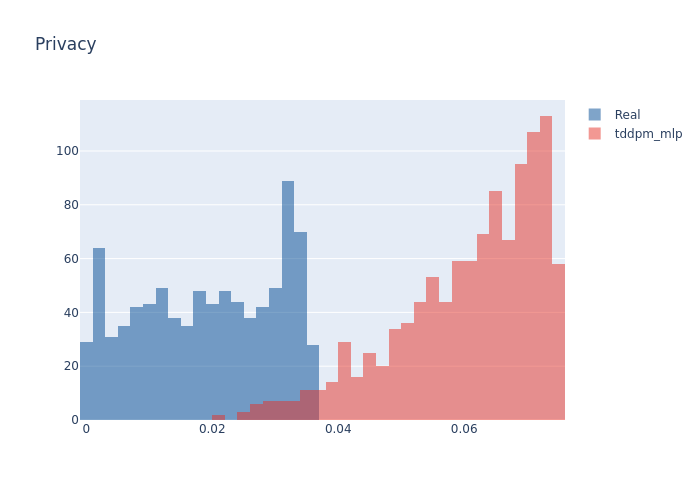

None

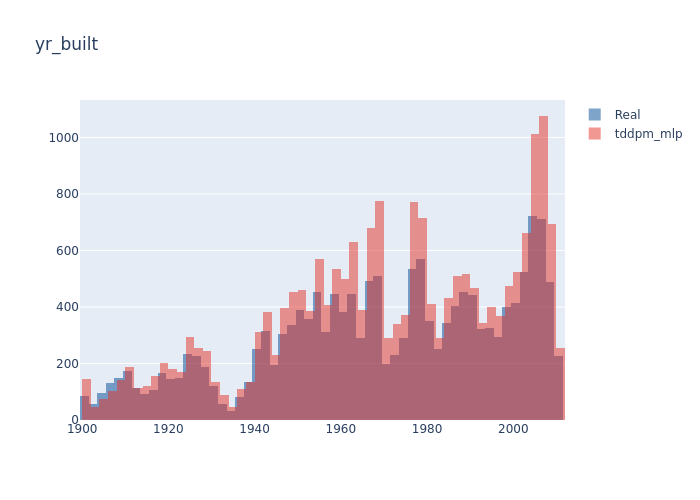

None

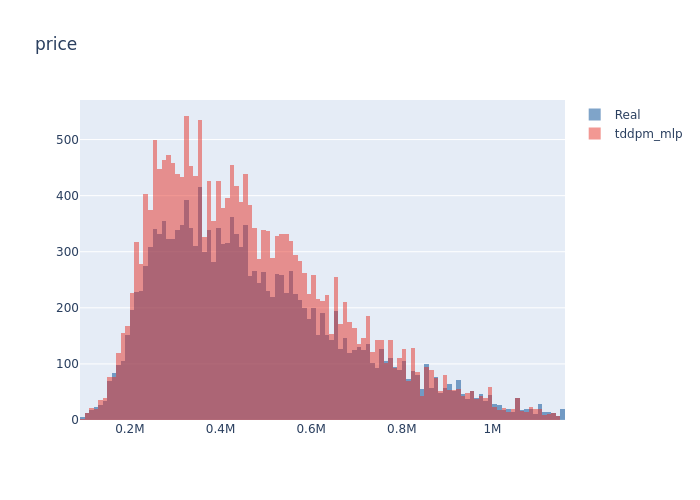

None

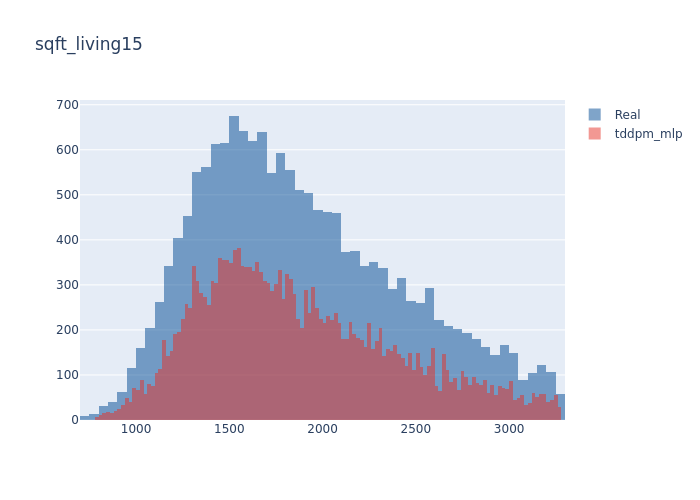

None

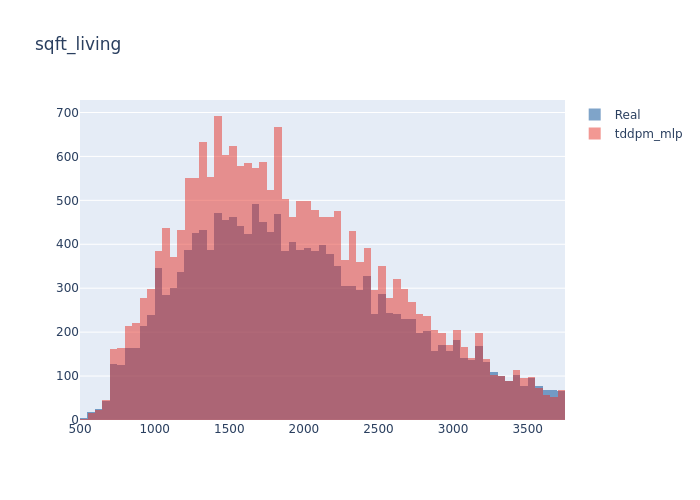

None

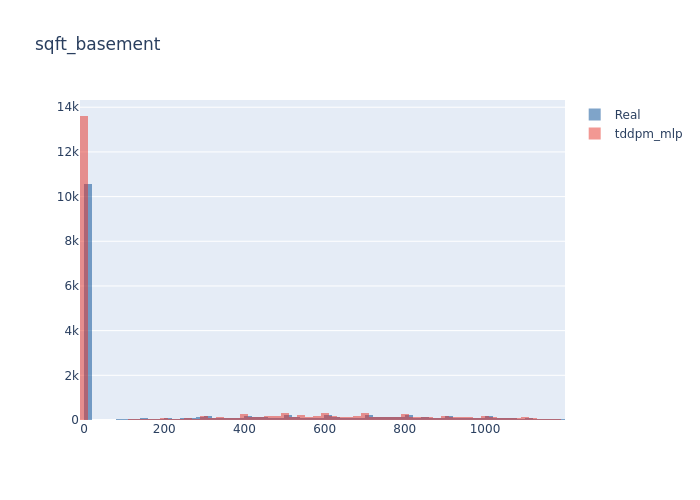

None

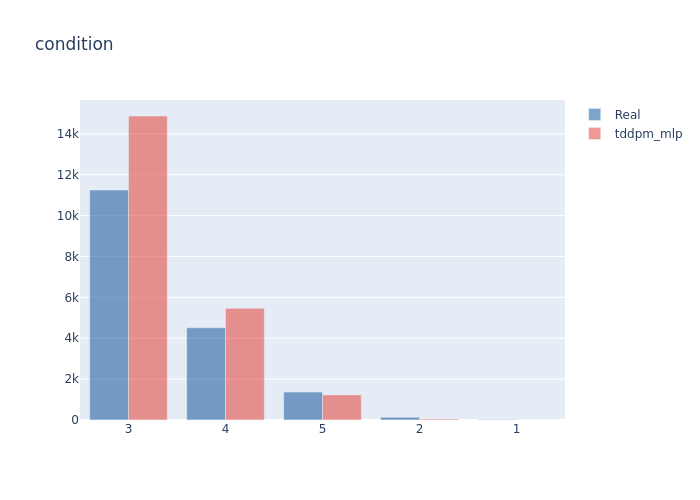

None

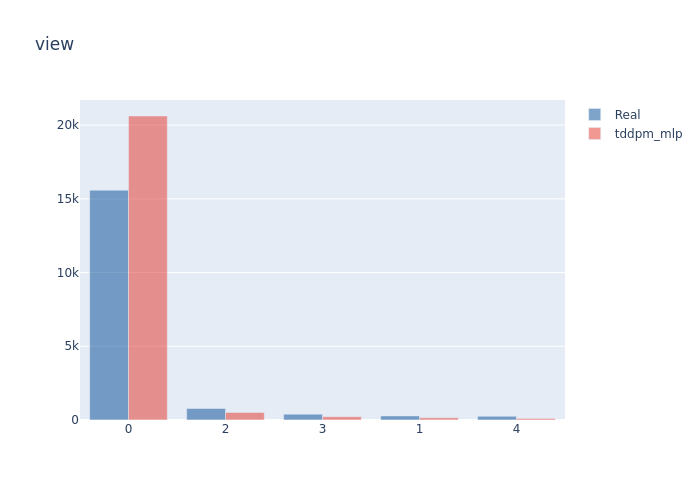

None

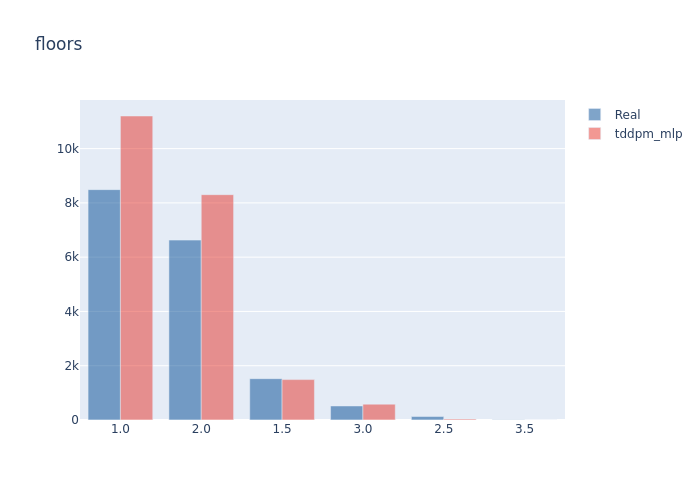

None

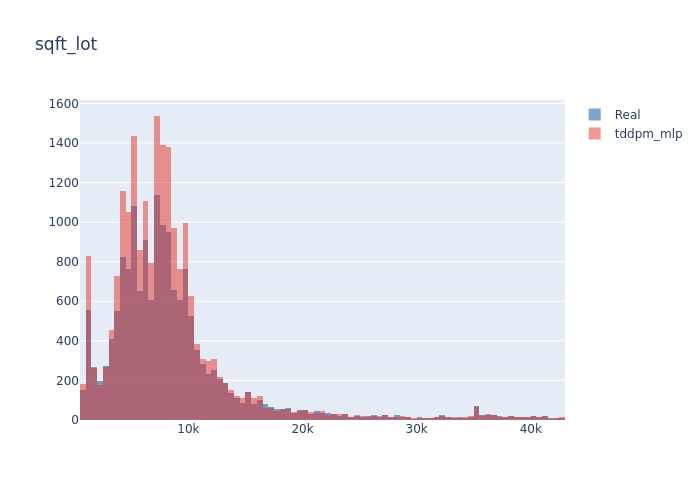

None

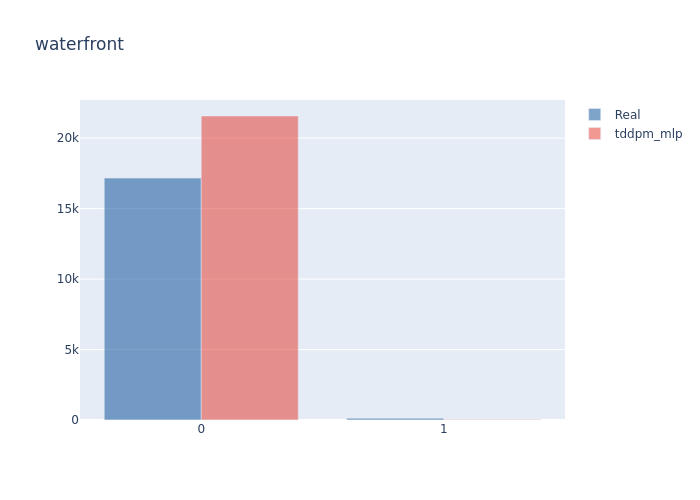

None

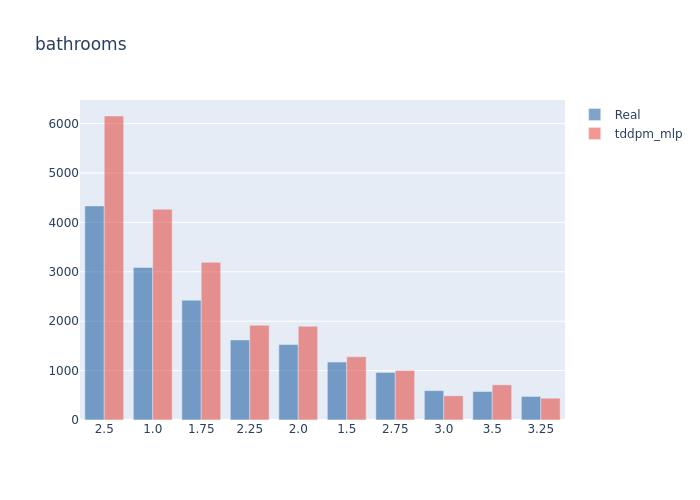

None

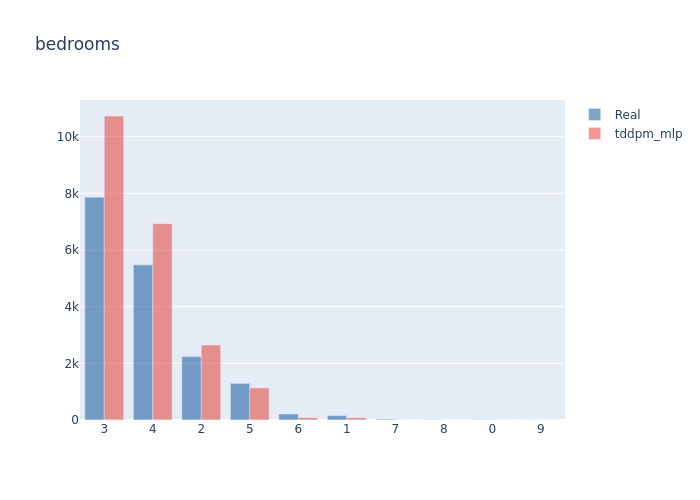

None

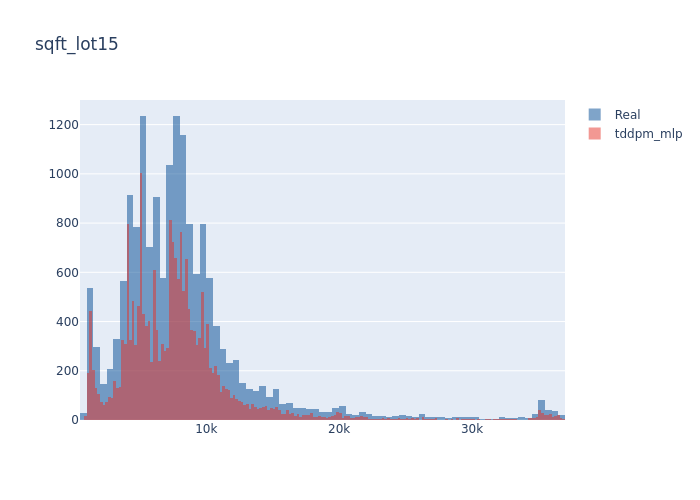

None

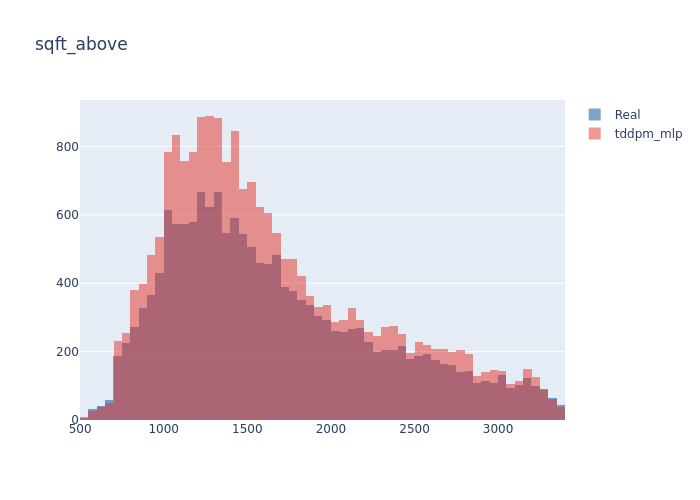

None

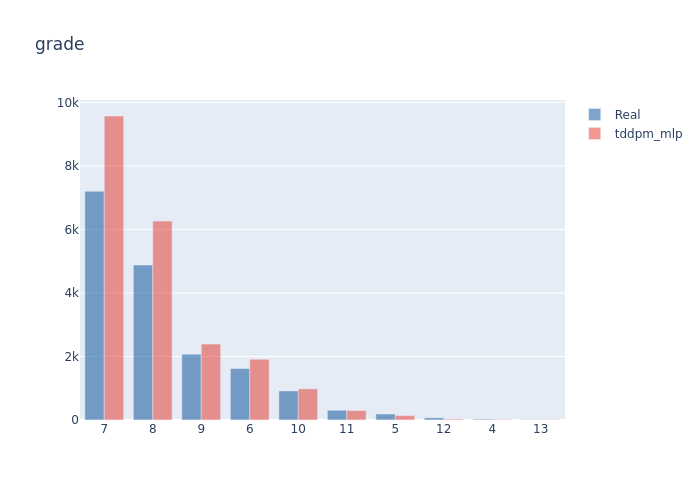

None

In [14]:
from syntheticml.data.charts import Charts
import os
folder_path = f"../docs/tesis/imagenes/kingcounty/{best_model}"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        file_name = f'{fig.layout.title.text.replace(":","").replace(" ","_").lower()}.svg'
        fig.write_image(f"{folder_path}/{file_name}")
        display(fig.show("png"))

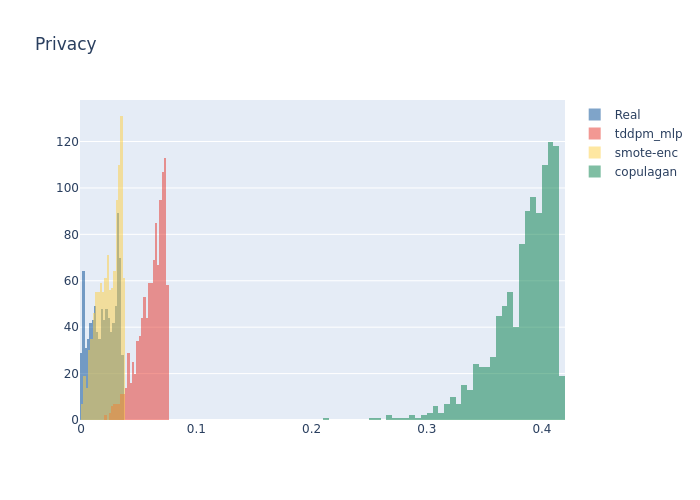

None

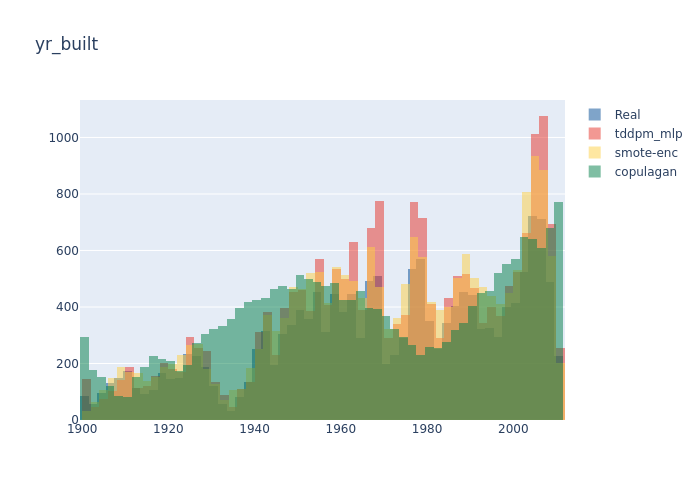

None

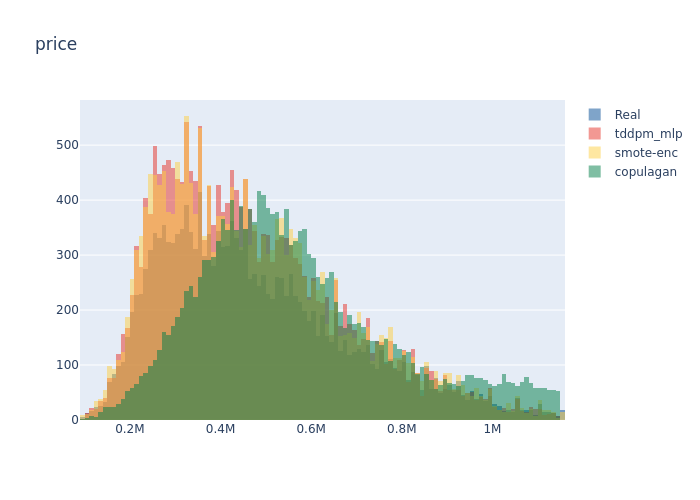

None

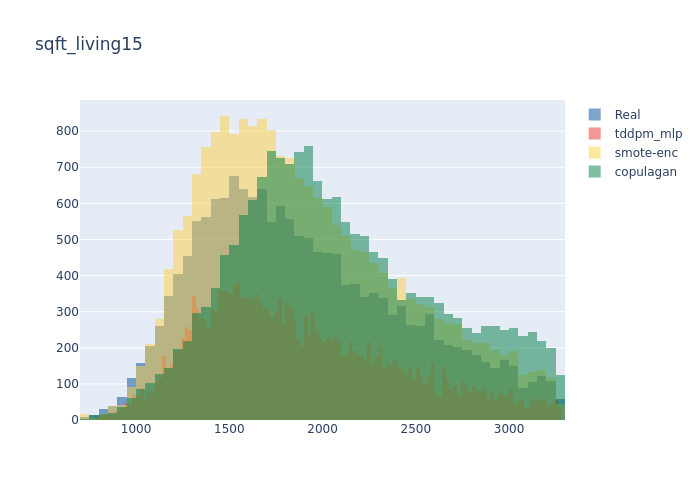

None

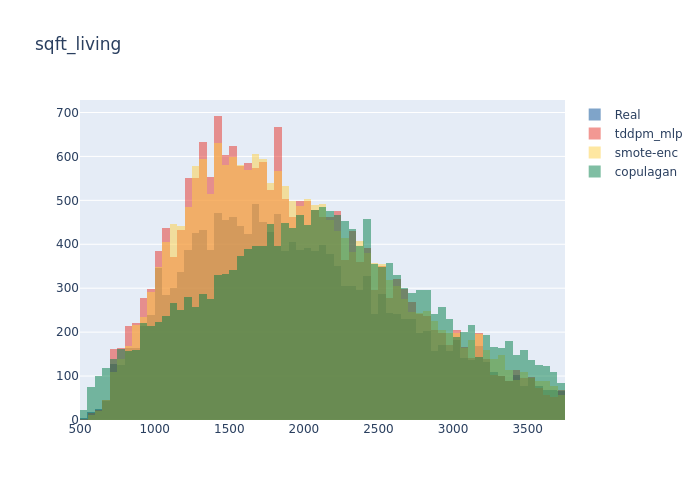

None

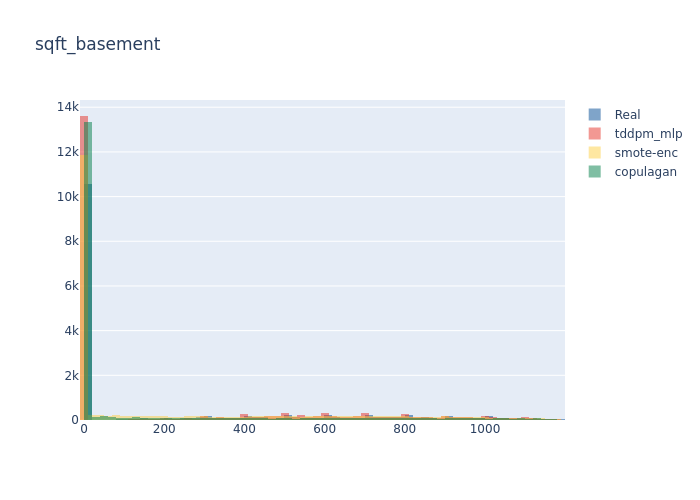

None

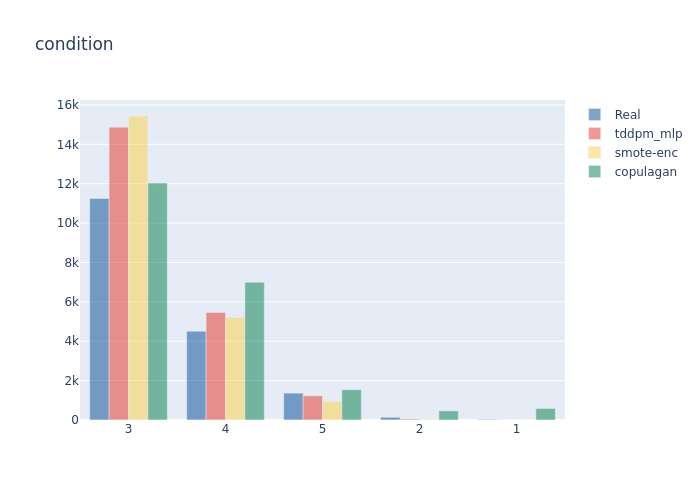

None

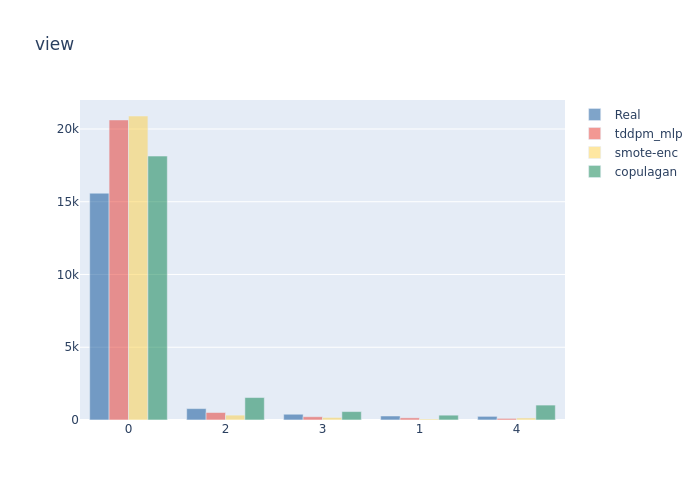

None

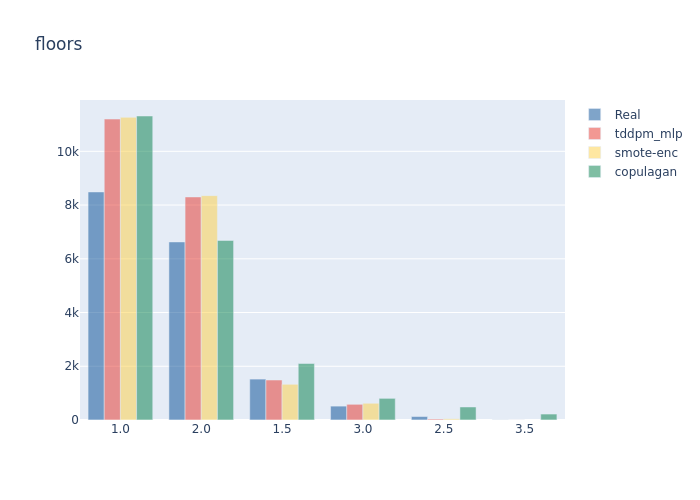

None

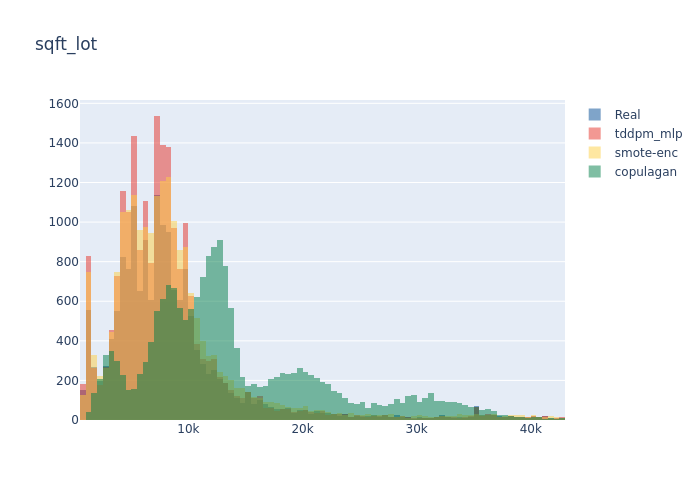

None

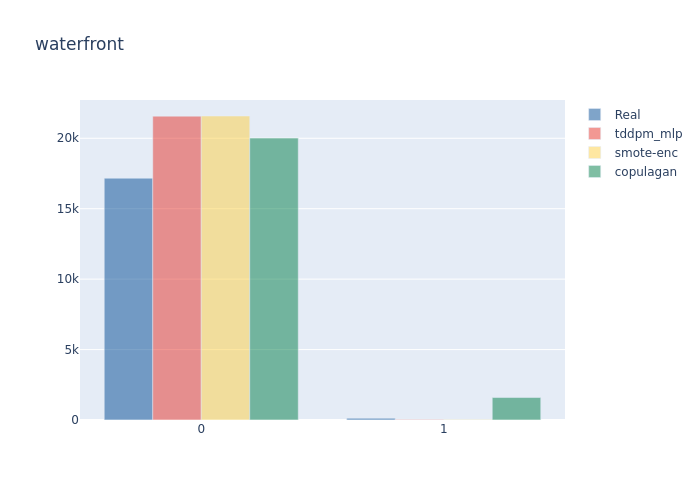

None

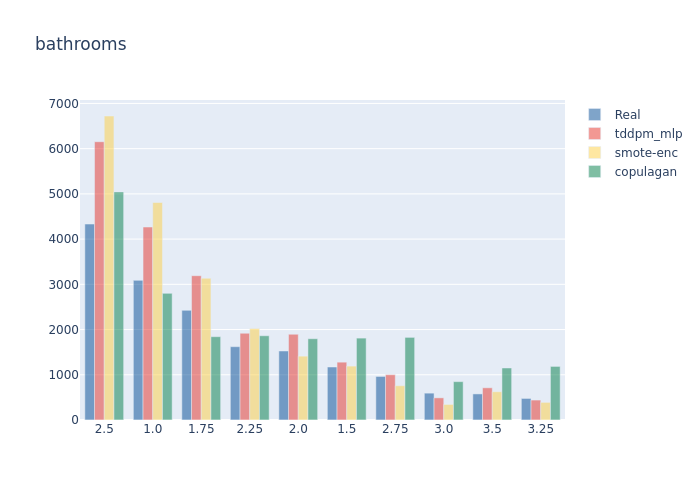

None

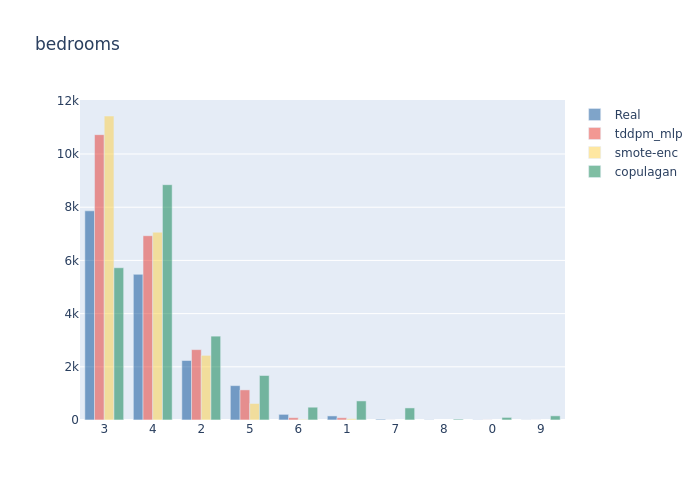

None

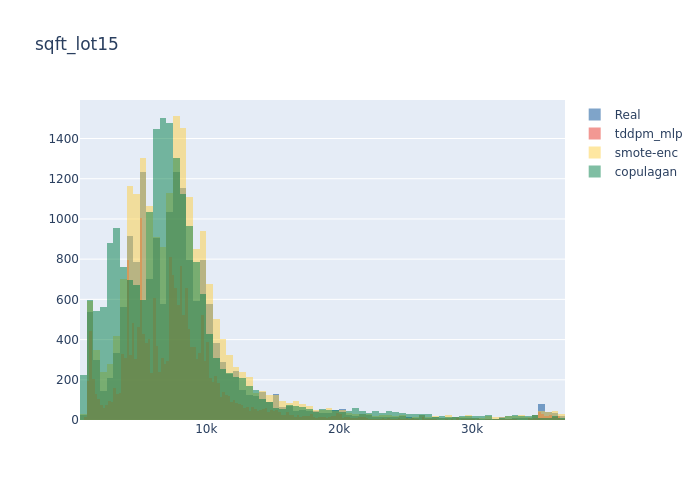

None

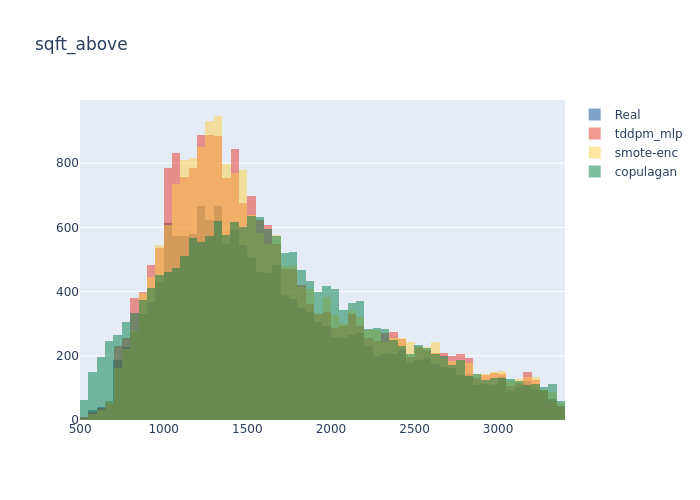

None

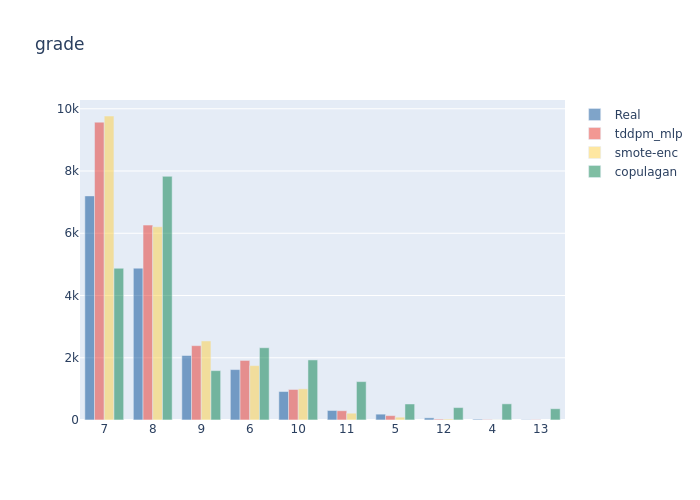

None

In [15]:
import os
folder_path = f"../docs/tesis/imagenes/kingcounty/top2+1"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
for fig in syn.get_multiple_charts([best_model,second_best_model,"copulagan"], {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        file_name = f'{fig.layout.title.text.replace(":","").replace(" ","_").lower()}.svg'
        fig.write_image(f"{folder_path}/{file_name}")
        display(fig.show("png"))


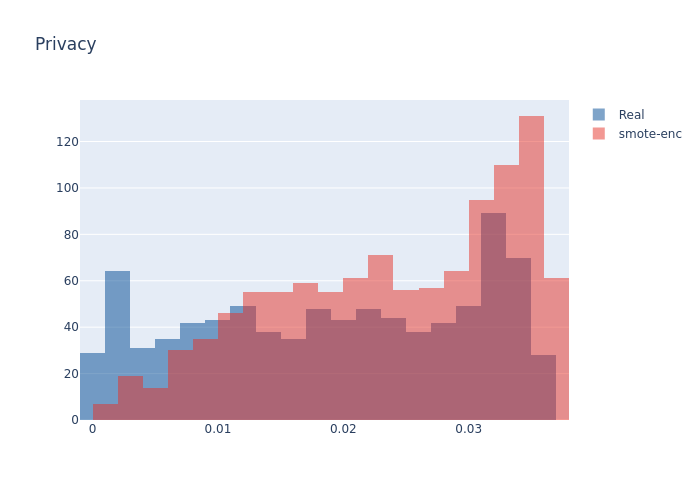

None

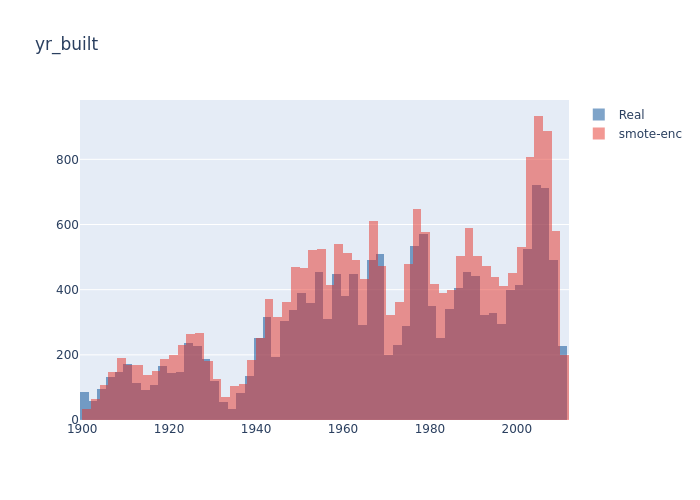

None

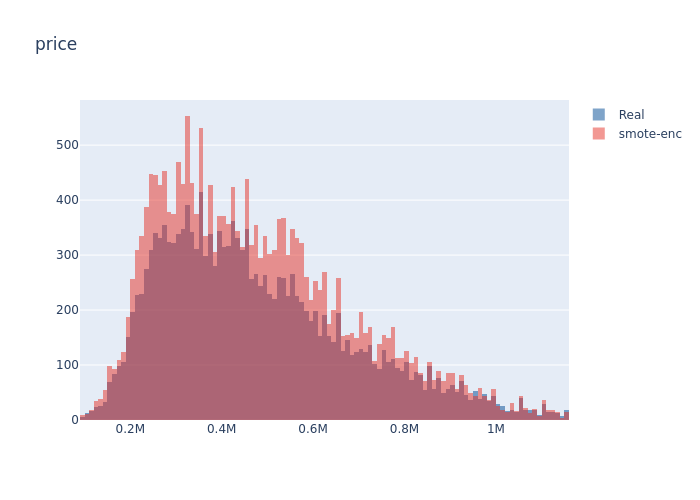

None

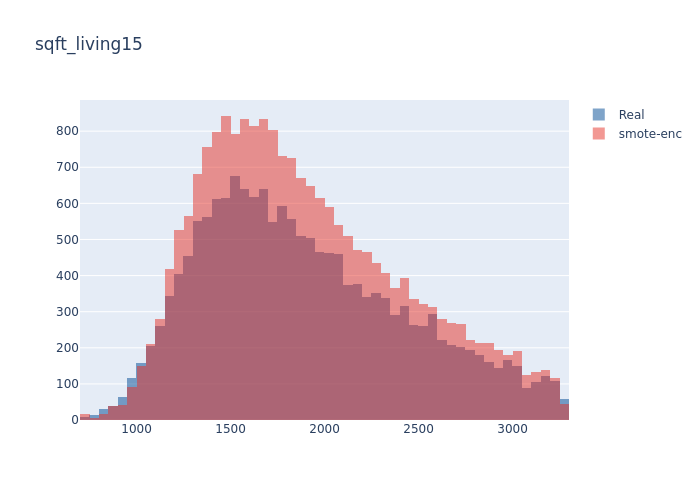

None

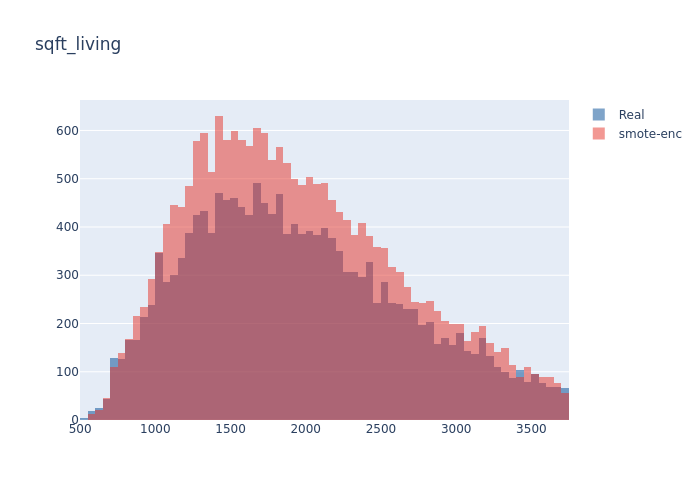

None

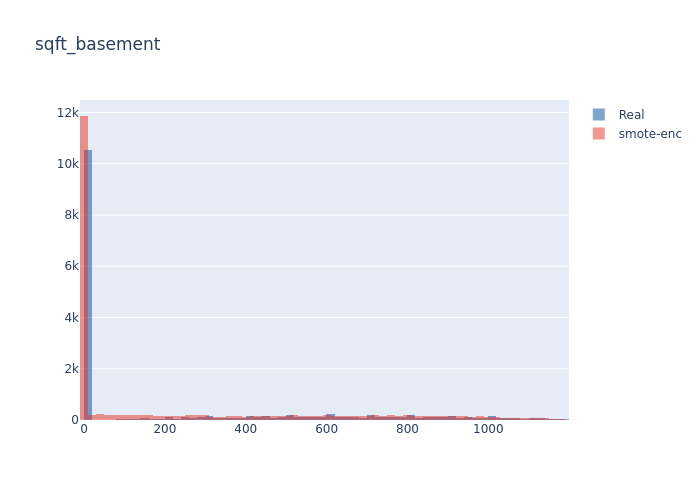

None

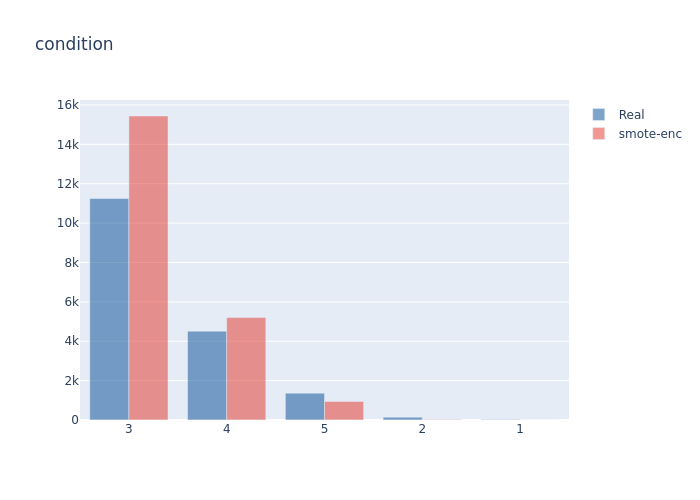

None

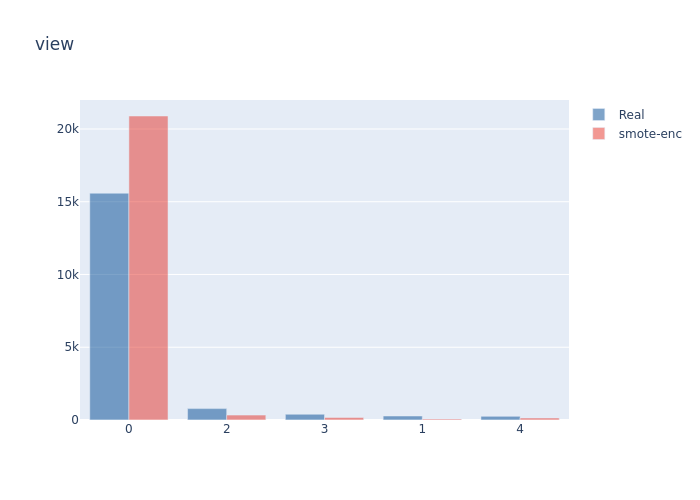

None

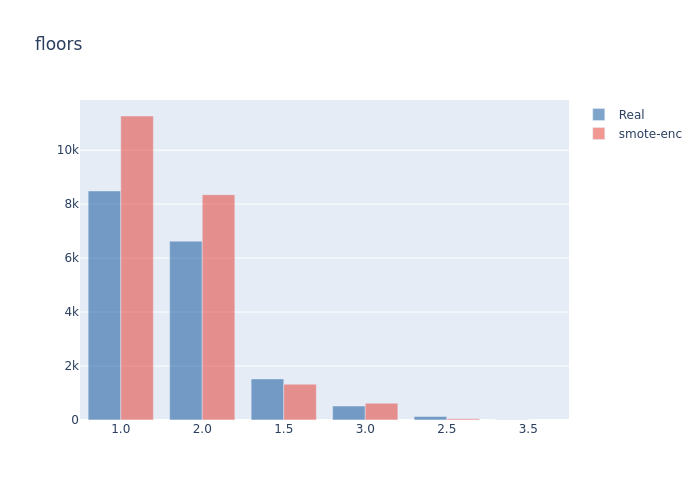

None

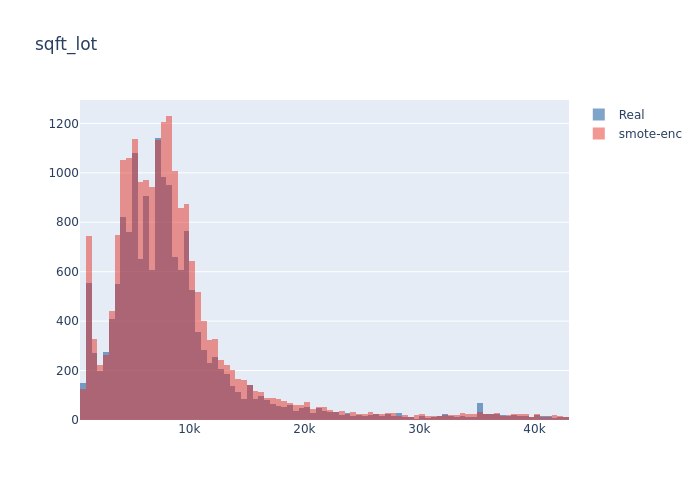

None

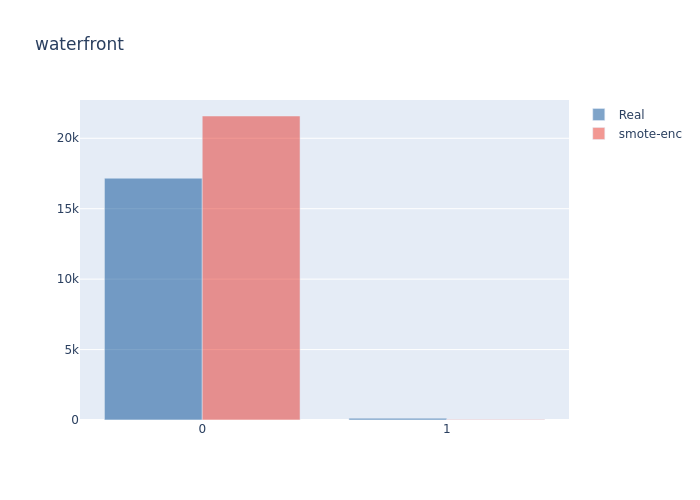

None

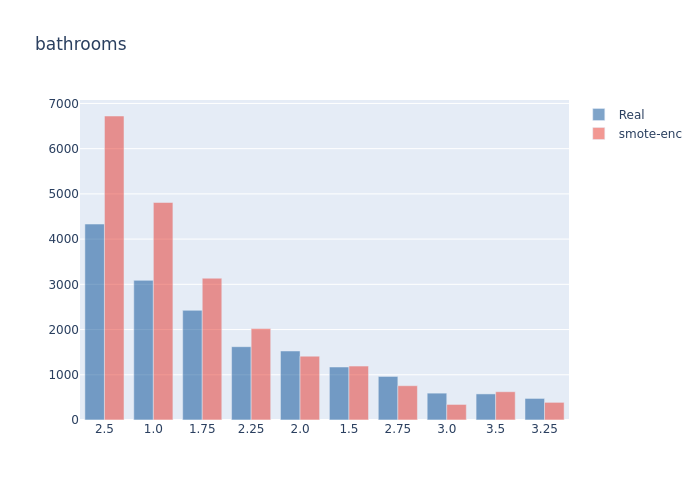

None

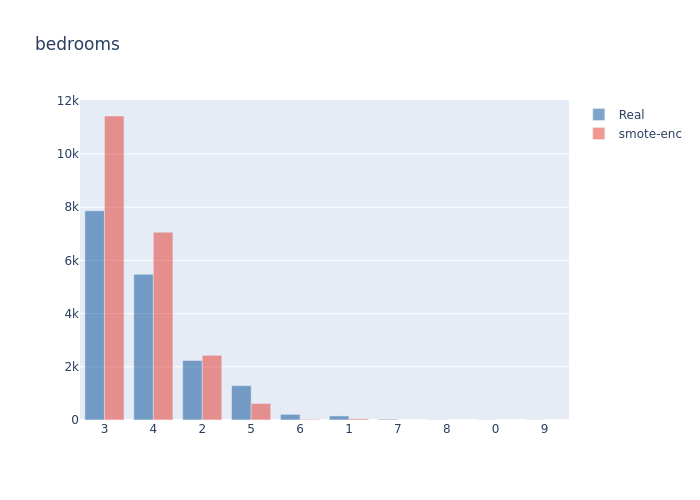

None

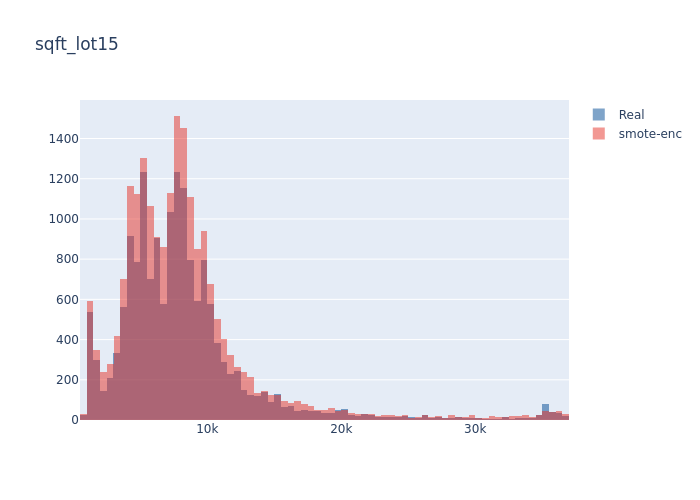

None

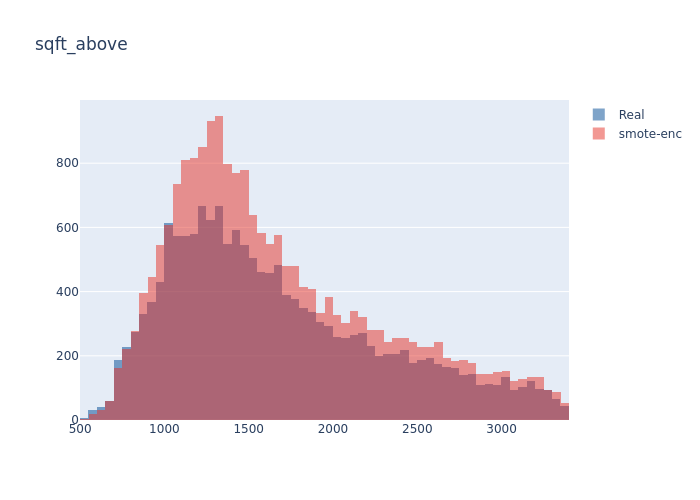

None

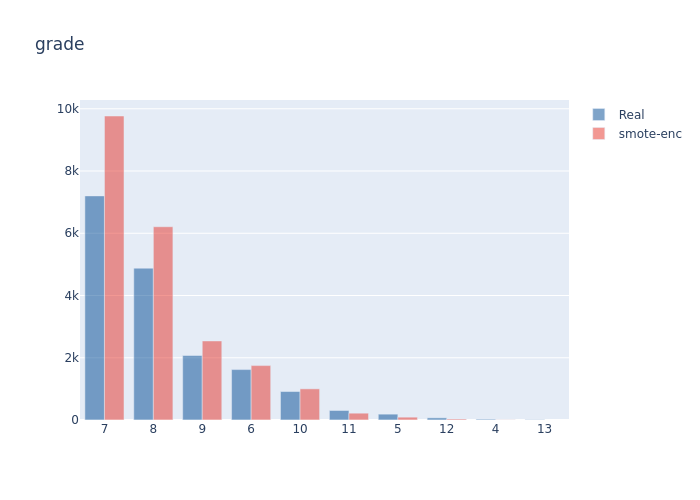

None

In [16]:
from syntheticml.data.charts import Charts
import os
folder_path = f"../docs/tesis/imagenes/kingcounty/{second_best_model}"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
for fig in syn.get_charts(second_best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        file_name = f'{fig.layout.title.text.replace(":","").replace(" ","_").lower()}.svg'
        fig.write_image(f"{folder_path}/{file_name}")
        display(fig.show("png"))

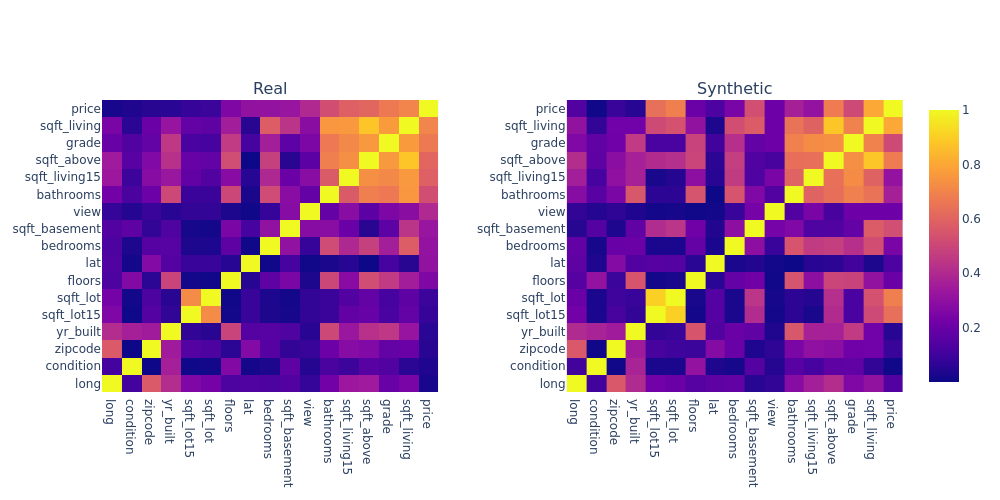

In [17]:
syn.charts.pair_corr(syn.df, syn.fake_data[best_model], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")

In [18]:
current_metrics = syn.current_metrics()
fake_metrics = syn.get_metrics_fake()

long
yr_renovated
price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living
yr_built
lat
sqft_basement
long
yr_renovated
price
sqft_living15
sqft_lot


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

sqft_lot15
sqft_above
sqft_living
yr_built
id
lat
sqft_basement
long
yr_renovated
price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

yr_built
id
lat
sqft_basement
long
yr_renovated
price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living
yr_built
id
lat
sqft_basement


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

long
yr_renovated
price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living
yr_built
id
lat
sqft_basement
long
yr_renovated


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

price
sqft_living15
sqft_lot
sqft_lot15
sqft_above
sqft_living
yr_built
id
lat
sqft_basement
long
yr_renovated
sqft_living15
price
sqft_lot


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

sqft_lot15
sqft_above
sqft_living
yr_built
id
lat
sqft_basement
long
yr_renovated
sqft_living15
price
sqft_lot
sqft_lot15
sqft_above
sqft_living


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core

yr_built
id
lat
sqft_basement


/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide

/root/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

/root/.local/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning:

invalid value encountered in divide



In [19]:
columns = ["bathrooms", "sqft_lot", "sqft_above", "price", "sqft_lot15", "sqft_living", "sqft_basement", "yr_built", "sqft_living15", "grade"]

In [20]:
current_metrics.loc[(current_metrics.name.isin(columns) & current_metrics.is_categorical),:].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
4,grade,"[7, 8, 9, 6, 10]","[7201, 4879, 2072, 1620, 915]","[0.4164835164835165, 0.28218623481781374, 0.11...",True,17290.0,17290.0
19,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[4333, 3088, 2425, 1621, 1526]","[0.2506072874493927, 0.17860034702139965, 0.14...",True,17290.0,17290.0


In [21]:
models = ["smote-enc", "tddpm_mlp"]
prop_cat = ["name", "top5", "top5_prob"]
import numpy as np
columns = list(current_metrics.name.unique())
dfs = [
    current_metrics.loc[(current_metrics.name.isin(columns) & current_metrics.is_categorical),prop_cat].dropna(axis=1, how='all').assign(model="Real")
]
for model_name in models:
    dfs.append(fake_metrics[model_name].loc[(fake_metrics[model_name].name.isin(columns) & fake_metrics[model_name].is_categorical),prop_cat].dropna(axis=1, how='all').assign(model=model_name))

diffdf = pd.concat(dfs).sort_values(["name", "model"], ascending=[True, True]).loc[:, ["model", "name"] + prop_cat[1:]]


for name in diffdf.name.unique():
    #print(name)
    #print(diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")) , ["top5_prob"]])
    #print(diffdf.loc[((diffdf.name == name) & (diffdf.model == "Real")), ["top5_prob"]])
    #diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")), ["top5_prob"]] = np.abs(diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")) , ["top5_prob"]].values
    #    - diffdf.loc[((diffdf.name == name) & (diffdf.model == "Real")), ["top5_prob"]].values)
    #print(
    #    np.array(np.abs(diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")) , ["top5_prob"]].values
    #    - diffdf.loc[((diffdf.name == name) & (diffdf.model == "Real")), ["top5_prob"]].values).tolist()).reshape(-1,5).sum(axis=1).reshape(-1,1)
    #)

    #diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")), ["top5_prob"]] = np.array(np.abs(diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")) , ["top5_prob"]].values
    #    - diffdf.loc[((diffdf.name == name) & (diffdf.model == "Real")), ["top5_prob"]].values).tolist()).reshape(-1,5).sum(axis=1).reshape(-1,1)

    #diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")), ["top5_prob"]] = np.array(np.abs(diffdf.loc[((diffdf.name == name) & (diffdf.model != "Real")) , ["top5_prob"]].values
    #- diffdf.loc[((diffdf.name == name) & (diffdf.model == "Real")), ["top5_prob"]].values).tolist()).sum(axis=2)
    pass
diffdf
#print(diffdf.style.to_latex().replace("_", "\_"))

,model,name,top5,top5_prob
19,Real,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[0.2506072874493927, 0.17860034702139965, 0.14..."
20,smote-enc,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[0.3110021282502082, 0.2225409456833534, 0.145..."
20,tddpm_mlp,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[0.28468977004580576, 0.19742747420533938, 0.1..."
9,Real,bedrooms,"[3, 4, 2, 5, 6]","[0.4548872180451128, 0.3167727009832273, 0.129..."
9,smote-enc,bedrooms,"[3, 4, 2, 5, 1]","[0.528823910428426, 0.32668640695845286, 0.112..."
9,tddpm_mlp,bedrooms,"[3, 4, 2, 5, 6]","[0.4963679267107759, 0.32059408689214824, 0.12..."
13,Real,condition,"[3, 4, 5, 2, 1]","[0.6505494505494506, 0.2609600925390399, 0.078..."
13,smote-enc,condition,"[3, 4, 5, 2, 1]","[0.7143055427038031, 0.24072360507078747, 0.04..."
13,tddpm_mlp,condition,"[3, 4, 5, 2, 1]","[0.6881043816221718, 0.25267200296118075, 0.05..."
14,Real,date,"[20140623T000000, 20140625T000000, 20140626T00...","[0.007113938692886061, 0.006072874493927126, 0..."


In [22]:
models = ["smote-enc", "tddpm_mlp"]
prop_cat = ["name", "range", "min", "1.0%", "mean", "99.0%", "max"]
import numpy as np
columns = list(current_metrics.name.unique())
dfs = [
    current_metrics.loc[(current_metrics.name.isin(columns) & ~current_metrics.is_categorical),prop_cat].dropna(axis=1, how='all').assign(model="Real")
]
for model_name in models:
    dfs.append(fake_metrics[model_name].loc[(fake_metrics[model_name].name.isin(columns) & ~fake_metrics[model_name].is_categorical),prop_cat].dropna(axis=1, how='all').assign(model=model_name))

diffdf = pd.concat(dfs).sort_values(["name", "model"], ascending=[True, True]).loc[:, ["model", "name"] + prop_cat[1:]]
diffdf

,model,name,range,min,1.0%,mean,99.0%,max
16,Real,lat,6.183000e-01,47.159300,47.257334,47.560330,4.777281e+01,4.777760e+01
17,smote-enc,lat,5.951025e-01,47.182335,47.252098,47.559667,4.777001e+01,4.777744e+01
17,tddpm_mlp,lat,6.217000e-01,47.155900,47.254433,47.558000,4.777046e+01,4.777760e+01
0,Real,long,1.204000e+00,-122.519000,-122.408000,-122.214139,-1.217870e+02,-1.213150e+02
0,smote-enc,long,1.200122e+00,-122.516336,-122.405129,-122.212658,-1.217996e+02,-1.213162e+02
0,tddpm_mlp,long,1.204000e+00,-122.519000,-122.400834,-122.216691,-1.217853e+02,-1.213150e+02
5,Real,price,7.625000e+06,75000.000000,154467.000000,537768.047947,1.950000e+06,7.700000e+06
6,smote-enc,price,3.722000e+06,78000.000000,152356.250000,518454.546775,1.712750e+06,3.800000e+06
6,tddpm_mlp,price,7.624813e+06,75187.489094,158734.660943,523632.429772,1.764468e+06,7.700000e+06
11,Real,sqft_above,8.570000e+03,290.000000,700.000000,1785.962175,4.371100e+03,8.860000e+03


In [23]:
k['smote-enc']['report']['column_pair_trends']
#k['smote-enc_21613']['report']['column_shape']

NameError: name 'k' is not defined

In [ ]:
pd.concat(
    [k[model_name]['report']['column_pair_trends'].loc[:,["Column 1", "Quality Score"]].groupby("Column 1").mean(numeric_only=True).assign(model=model_name) for model_name in models]
).reset_index().pivot(index=["Column 1"], values="Quality Score", columns="model").sort_values("smote-enc", ascending=False)

model,smote-enc,tddpm_mlp
Column 1,,
lat,0.986839,0.979846
long,0.985730,0.977739
id,0.984325,0.966410
sqft_basement,0.982133,0.979724
price,0.979326,0.977921
waterfront,0.978698,0.964651
sqft_lot15,0.978543,0.971079
sqft_living,0.978398,0.968794
sqft_above,0.977744,0.972651


In [ ]:
display(
    pd.concat(
    [k[model_name]['report']['column_shape'].assign(model=model_name) for model_name in models]
).pivot(index=["Column","Metric"], values="Quality Score", columns="model").sort_values("smote-enc", ascending=False)
#.style.to_latex().replace("_", "\_")
)

,model,smote-enc,tddpm_mlp
Column,Metric,,
waterfront,TVComplement,0.993800,0.994263
yr_renovated,KSComplement,0.992827,0.990608
lat,KSComplement,0.992164,0.979040
long,KSComplement,0.991543,0.978994
id,KSComplement,0.986672,0.972748
price,KSComplement,0.983755,0.978670
sqft_living,KSComplement,0.982265,0.976079
sqft_lot,KSComplement,0.981703,0.974321
sqft_lot15,KSComplement,0.981608,0.972702


In [ ]:
f = pd.concat(
    [
        k[model_name]['diagnostic']['coverage'].assign(model=model_name) 
        for model_name in models
    ]
    ).pivot(index=["Column","Metric"], 
            values="Diagnostic Score", columns="model").sort_values("smote-enc", ascending=False).reset_index().rename(columns={"Column": "Columna", "Metric":"Metrica", "smote-enc":"smote-enc $\\uparrow$"})


display(
    f.style.hide(axis=0)
)

Columna,Metrica,smote-enc $\uparrow$,tddpm_mlp
zipcode,CategoryCoverage,1.000000,1.000000
condition,CategoryCoverage,1.000000,1.000000
waterfront,CategoryCoverage,1.000000,1.000000
view,CategoryCoverage,1.000000,1.000000
yr_built,RangeCoverage,1.000000,1.000000
yr_renovated,RangeCoverage,0.999967,1.000000
id,RangeCoverage,0.993545,1.000000
long,RangeCoverage,0.992872,1.000000
sqft_lot15,RangeCoverage,0.986852,1.000000
lat,RangeCoverage,0.964585,1.000000


In [ ]:
pair_trends = k['smote-enc']['report']['column_pair_trends']
pair_trends[pair_trends['Column 1'] == "price"]

,Column 1,Column 2,Metric,Quality Score,Real Correlation,Synthetic Correlation
11,price,sqft_living,CorrelationSimilarity,0.970760,0.702035,0.643555
12,price,sqft_lot,CorrelationSimilarity,0.987185,0.089661,0.064031
13,price,sqft_above,CorrelationSimilarity,0.970775,0.605567,0.547118
14,price,sqft_basement,CorrelationSimilarity,0.988944,0.323816,0.301703
15,price,yr_built,CorrelationSimilarity,0.994667,0.054012,0.043346
16,price,yr_renovated,CorrelationSimilarity,0.990406,0.126434,0.145622
19,price,sqft_living15,CorrelationSimilarity,0.996171,0.585379,0.577722
20,price,sqft_lot15,CorrelationSimilarity,0.990261,0.082447,0.062968
125,price,waterfront,ContingencySimilarity,0.983755,NaN,NaN
126,price,view,ContingencySimilarity,0.938461,NaN,NaN
